### Imports

In [23]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import feature_selection
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from IPython.core.pylabtools import figsize 
%matplotlib inline

### Aux Functions

### Analysis

In [9]:
# varq = pd.read_csv("../data/processed/properties-varq.tab.gz", sep="\t", index_col="MUTANT")
# varq = pd.read_csv("../data/processed/humsavar_varq_gt.csv.gz", sep=",", index_col="MUTANT").drop("dbSNP", 1)
varq = pd.read_csv("../data/processed/varq_clean.csv.gz", index_col="MUTANT")
varq = varq[varq.TYPE != "Unclassified"].drop("ACTIVE_SITE", 1)

In [25]:
varq.columns

Index(['SASA', 'SASA_PERCENTAGE', 'BFACTOR', 'SWITCHBILITY', 'AGGREGABILITY',
       'CONSERVATION', '3DID', 'PDB', 'VARIATION_ENERGY', 'TYPE'],
      dtype='object')

In [26]:
varq.index.unique().shape

(7418,)

In [27]:
print("Size: \n", varq.shape)
print("\nValue counts of TYPE: \n", varq.TYPE.value_counts())

Size: 
 (7418, 10)

Value counts of TYPE: 
 Pathogenic    5377
Benign        2041
Name: TYPE, dtype: int64


In [28]:
varq.describe()

,SASA,SASA_PERCENTAGE,BFACTOR,SWITCHBILITY,AGGREGABILITY,CONSERVATION,VARIATION_ENERGY
count,7070.000000,7070.000000,7070.000000,6704.000000,5335.000000,2742.000000,7418.000000
mean,32.105675,0.150610,56.445569,0.384835,5.017957,0.330460,2.914977
std,39.148405,0.176877,71.760154,0.890387,17.607171,0.188785,4.842729
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.130000,-12.642100
25%,0.670000,0.000000,19.765000,0.000000,0.000000,0.250000,0.257785
50%,15.208000,0.070000,37.342500,0.009150,0.000000,0.300000,1.512550
75%,52.149250,0.270000,61.138125,0.277000,0.163000,0.370000,3.885900
max,246.410000,0.750000,755.610000,8.720000,100.000000,4.770000,57.513400


In [29]:
corr = varq.drop(['3DID', 'PDB'], axis=1).corr()

In [30]:
corr

,SASA,SASA_PERCENTAGE,BFACTOR,SWITCHBILITY,AGGREGABILITY,CONSERVATION,VARIATION_ENERGY
SASA,1.000000,0.963621,0.079879,-0.038746,0.014785,0.016618,-0.349207
SASA_PERCENTAGE,0.963621,1.000000,0.112154,-0.044397,0.019902,0.028529,-0.373402
BFACTOR,0.079879,0.112154,1.000000,0.055923,0.151166,-0.026455,-0.081219
SWITCHBILITY,-0.038746,-0.044397,0.055923,1.000000,0.032105,0.025763,-0.030136
AGGREGABILITY,0.014785,0.019902,0.151166,0.032105,1.000000,-0.009340,-0.041672
CONSERVATION,0.016618,0.028529,-0.026455,0.025763,-0.009340,1.000000,-0.033151
VARIATION_ENERGY,-0.349207,-0.373402,-0.081219,-0.030136,-0.041672,-0.033151,1.000000


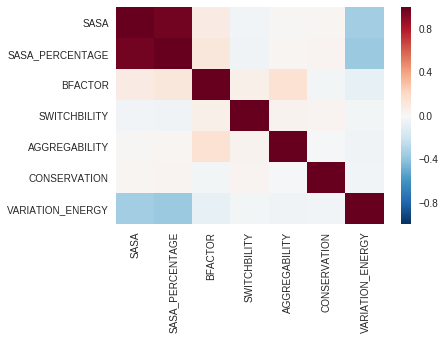

In [31]:
plot = sns.heatmap(corr)
figure = plot.get_figure()

### Machine Learning

In [56]:
# feature_union = 
impute = ('imputer', Imputer(missing_values="NaN", strategy="median"))
scale = ('scaler', StandardScaler())

model_dict = {
    'lr':{'pipe':[impute, scale, ('lr', LogisticRegression())],
        'params':[{'lr__C' : [.001, .01, .1, 1, 10, 100, 1000], 'lr__class_weight':[None, 'balanced']}],
        'name':'LogisticRegression'
    },
    'rf':{'pipe':[impute, ('rf', RandomForestClassifier(random_state = 100))],
        'params':[{'rf__max_depth':[3,5,7], 'rf__n_estimators':[10,50,100], 'rf__max_features':[4,'sqrt',0.2]}],
        'name':'Random Forest'
    },
    'svc':{'pipe': [impute, scale, ('svc', SVC(kernel='rbf'))],
           'params':[{'svc__kernel': ['rbf'], 'svc__gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                'svc__C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}]
        
    },
}

In [57]:
le = LabelEncoder()

X = varq[~varq.TYPE.isnull()].drop(['3DID', 'PDB', 'TYPE'], 1)

# .replace({"ACTIVE_SITE": {"BINDING": 1, np.nan: 0}})
y = le.fit_transform(varq[~varq.TYPE.isnull()].TYPE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

#### Random Forest

In [58]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
algorithm = 'rf'
model = Pipeline(model_dict[algorithm]['pipe'])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=2, 
                  scoring='roc_auc', verbose=1, refit=True)

In [59]:
X_test.shape

(2448, 7)

In [60]:
pd.Series(y_test).value_counts()

1    1774
0     674
dtype: int64

In [61]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  78 out of  81 | elapsed:    7.1s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    7.6s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f6ebb244150>,
       error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_spl...imators=10, n_jobs=1, oob_score=False, random_state=100,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=2,
       param_grid=[{'rf__max_depth': [3, 5, 7], 'rf__n_estimators': [10, 50, 100], 'rf__max_features': [4, 'sqrt', 0.2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [62]:
rf = gs.best_estimator_

In [63]:
gs.best_score_

0.73527168270566057

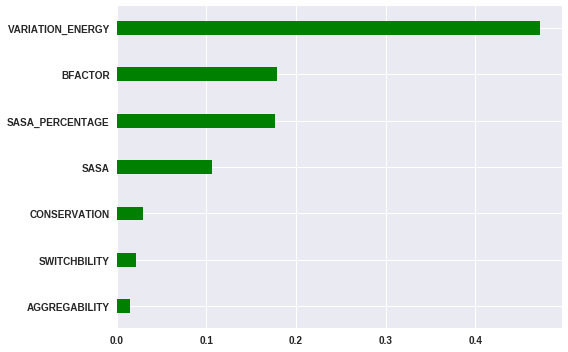

In [64]:
# importances = [(x_train.columns[e], x) for e, x in enumerate(rf.steps[1][1].feature_importances_)]
# importances.sort(key=operator.itemgetter(1), reverse=True)
# figsize(8,5)
# plt.title("Feature importances", fontsize=16)
# plt.bar(np.arange(len(importances)), [y for x, y in importances], color="g", align="center")
# plt.xticks(range(len(importances)), [x for x, y in importances], rotation='vertical', fontsize=16)
# # plt.xlim([0, range(len(importances))])
# plt.show()


importances = [(X_train.columns[e], x) for e, x in enumerate(rf.steps[1][1].feature_importances_)][:10]
importances.sort(key=operator.itemgetter(1), reverse=False)
figsize(8, 5)
# plt.title("Importancia", fontsize=16)
plt.barh(np.arange(len(importances)), [y for x, y in importances], 0.3, color="g", align="center")
plt.yticks(range(len(importances)), [x for x, y in importances], rotation='horizontal', fontsize=10, fontweight='bold')
plt.xticks(fontweight='bold')
# plt.xlim([0, range(len(importances))])
# plt.show()
plt.tight_layout()

# plt.savefig("../documents/latex/figures/varq/importances_varq.pdf", bbox_inches='tight', pad_inches=0.1)


In [65]:
y_test

array([1, 1, 1, ..., 1, 1, 1])

In [66]:
print(classification_report(y_test, rf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.58      0.27      0.37       674
          1       0.77      0.92      0.84      1774

avg / total       0.72      0.74      0.71      2448



In [67]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [68]:
fpr.shape

(902,)

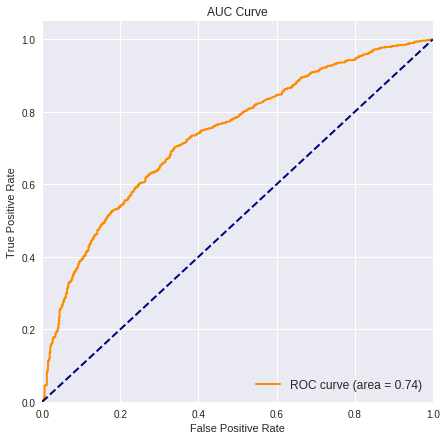

In [69]:
figsize(7,7)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve')
plt.legend(loc="lower right", prop={'size': 12})

plt.savefig("../documents/latex/figures/3/auc_varq.pdf", bbox_inches='tight', pad_inches=0.1)

#### Logistic Regression

In [70]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
algorithm = 'lr'
model = Pipeline(model_dict[algorithm]['pipe'])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=2, 
                  scoring='roc_auc', verbose=1, refit=True)

In [71]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=2)]: Done  42 out of  42 | elapsed:    0.6s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f6ebe985f10>,
       error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=2,
       param_grid=[{'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'lr__class_weight': [None, 'balanced']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [72]:
lr = gs.best_estimator_

In [73]:
gs.best_score_

0.71280347074685968

In [77]:
lr.steps[2]

('lr',
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False))

In [78]:
importances = list(zip(X_train.columns.tolist(), lr.steps[2][1].coef_[0].tolist()))

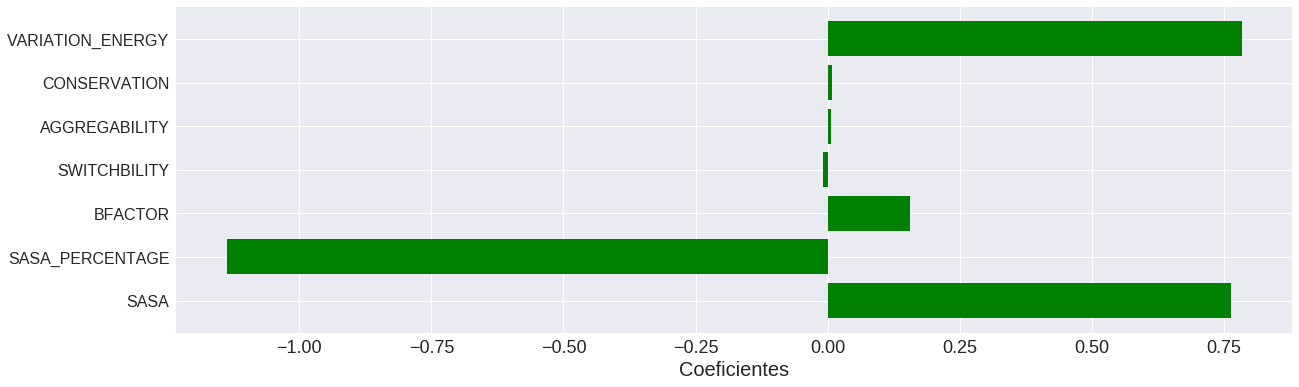

In [86]:
figsize(20,6)
# plt.title("Logistic Regression Coefficients", fontsize=16)
plt.barh(np.arange(len(importances)), [y for x, y in importances], color="g", align="center")
plt.xlabel("Coeficientes", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(range(len(importances)), [x for x, y in importances], rotation='horizontal', fontsize=16)
# plt.xticks(np.arange(-1.1,.7,.05))
plt.show()